<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=125145276" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [7]:
#  ! pip install imutils -q

import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request


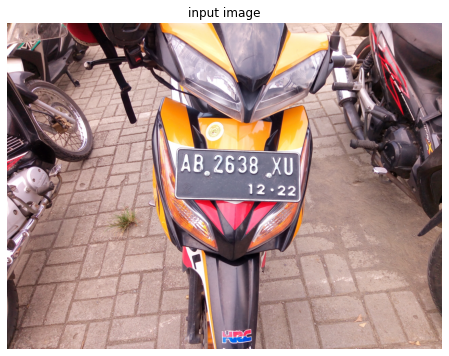

In [107]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB2638XU.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB5592EG.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AD2914JG.jpg')


arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

# program untuk mendeteksi posisi plat nomor dari motor


detected plat no: 3
2102


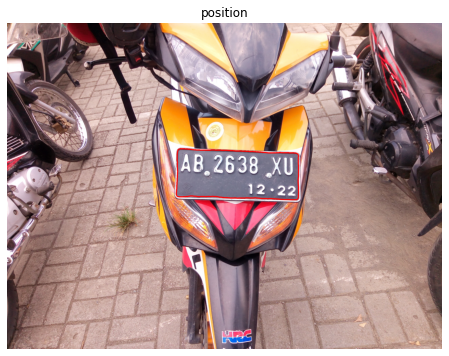

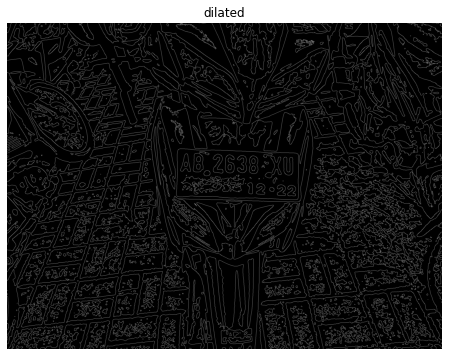

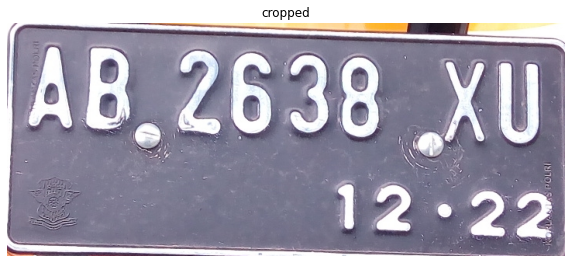

In [108]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H4517TI2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# req = urllib.request.urlopen('https://t-2.tstatic.net/gorontalo/foto/bank/images/12102022_plat-nomor-putih.jpg')

# req = urllib.request.urlopen('https://image.cermati.com/q_70,w_1200,h_800,c_fit/cgbt1mggrzxkk5p5xtot')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (19,19), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)

platno=[]
index=0
sx = sy = sw = sh =[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
#     print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
    if w > 500 and h>200 and aspect_ratio <= 4 : 
        platno.append(index)
        sx.append(x)
        sy.append(y)
        sh.append(w)
        sw.append(h)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) == 1 or len(platno)>=1:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    cv2.drawContours(detectedimg, contours, indexplatno, (0, 0, 255), 5)
    croppedimg = img[y: y+h, x:x+w]

print(indexplatno)

# display(hisimg, "contour")
# display(edged, "edged")
display(detectedimg, "position")
display(dilate, "dilated")
display(croppedimg, "cropped")



# program untuk mendeteksi digit dari plat nomor motor

In [109]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC1.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6498SI.jpg')

# req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/a/a5/Plat_Nomor_Nganjuk_%283_Huruf%29.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1)

# img = cv2.pyrDown(img)
grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (21,21), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h
#     print(f'aspect ratio from index: {index}, aspectRatio: {aspect_ratio}, w: {w}, h: {h}')
    if w > 42 and h>=70 and h <300 and aspect_ratio <= 0.7 and y<150: 
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

for a in platno:
    xa,ya,wa,ha = cv2.boundingRect(contour[a])
#     print("=========================")
    for b in platno:
        if a == b:
            continue
        else:
            xb,yb,wb,hb = cv2.boundingRect(contour[b])
            ydif = ya-yb
            xdif = xa-xb
            wdif = wa-wb
            hdif = ha-hb
#             print(f'ydif: {ydif}, xdif: {xdif}, wdif: {wdif}, hdif: {hdif}')
            
counter=0
score=np.zeros(len(platno))
for a in platno:
    xa, ya, wa, ha = cv2.boundingRect(contours[a])
#     print("============================")
    for b in platno:
        if a == b :
            continue
        else:
            xb, yb, wb, hb = cv2.boundingRect(contours[b])
            ydif = ya-yb
#             print(f'ya: {ya}, yb: {yb}, ydif: {ydif}')
            
            if ydif<11:
                score[counter] = score[counter]+1
            
    counter += 1

indexRealChar=[]
charCounter=0
for sc in score:
    if sc != max(score):
        indexRealChar.append(platno[charCounter])
        
    charCounter+=1
    
print(indexRealChar)
finalimg = croppedimg.copy()
for char in indexRealChar:
    x,y,w,h = cv2.boundingRect(contours[char])
    cv2.rectangle(finalimg, (x,y), (x+w,y+h), (150,0,0),2)
    
# display(imgrec, "box plat no")
# display(finalimg, "final hopefully")
# display(hisimg, "detected plat no")
# display(blured, "detected plat no")
# display(image_copy, "contour")
# display(edged, "edged")
# display(dilate, "dilated")
urutx = []
for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    urutx.append(x)
urutx = sorted(urutx)

## urutkan karakter plat nomor dari kiri ke kanan
cropCharUrut=[]
for ux in urutx:
    for char in platno :
        x,y,w,h = cv2.boundingRect(contours[char])
        if x == ux: 
            cropCharUrut.append(char)
            break
    

print(cropCharUrut)


x: 630, y: 48, w: 59, h: 110
x: 428, y: 41, w: 55, h: 108
x: 358, y: 39, w: 58, h: 105
x: 287, y: 35, w: 56, h: 110
x: 215, y: 29, w: 62, h: 117
x: 98, y: 28, w: 62, h: 112
x: 24, y: 28, w: 62, h: 109
detected candidate plat no: 7
[28, 30, 31]
[36, 35, 34, 32, 31, 30, 28]


# **Selanjutnya buat program untuk ekstract setiap digit dari plat nomor dan melakukan klasifikasi karakter yang didapatkan**

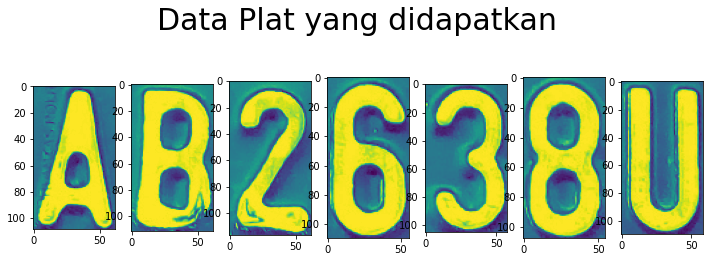

In [110]:
# tampilkan karakter yang telah terpotong
imgs=[]
for char in cropCharUrut:
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    imgs.append(crop)

# buat 1 plot dan tampilkan 
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,'Data Plat yang didapatkan',fontsize=30,ha='center')
plt.show()

# Buat Model Untuk Klasifikasi 
## **Nek meh ubah" / edit, nggawe Cell dewe, trus jenengi, ngen ra bingung**

In [111]:
"""
Cell nggone AH... Ojo diubah ubah
Buat Model dari tutorial:
https://www.tensorflow.org/tutorials/images/classification
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

path = '/kaggle/input/dataset-characters-indo-plate/dataset_characters'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

numClass = len(className)

# buat model dengan tensorflow sequential
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model.summary()

Found 36041 files belonging to 36 classes.
Using 28833 files for training.
Found 36041 files belonging to 36 classes.
Using 7208 files for validation.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 40, 40, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 40, 40, 16)        448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None,

In [23]:
epochs=10
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

Epoch 1/10
902/902 [==============================] - 127s 141ms/step - loss: 0.5537 - accuracy: 0.8532 - val_loss: 0.2698 - val_accuracy: 0.9276
Epoch 2/10
902/902 [==============================] - 56s 62ms/step - loss: 0.1862 - accuracy: 0.9492 - val_loss: 0.1770 - val_accuracy: 0.9496
Epoch 3/10
902/902 [==============================] - 56s 62ms/step - loss: 0.1194 - accuracy: 0.9657 - val_loss: 0.1636 - val_accuracy: 0.9528
Epoch 4/10
902/902 [==============================] - 57s 63ms/step - loss: 0.0857 - accuracy: 0.9742 - val_loss: 0.1487 - val_accuracy: 0.9574
Epoch 5/10
902/902 [==============================] - 57s 63ms/step - loss: 0.0643 - accuracy: 0.9809 - val_loss: 0.1981 - val_accuracy: 0.9459
Epoch 6/10
902/902 [==============================] - 57s 63ms/step - loss: 0.0512 - accuracy: 0.9861 - val_loss: 0.1418 - val_accuracy: 0.9618
Epoch 7/10
902/902 [==============================] - 57s 63ms/step - loss: 0.0444 - accuracy: 0.9868 - val_loss: 0.1580 - val_accurac

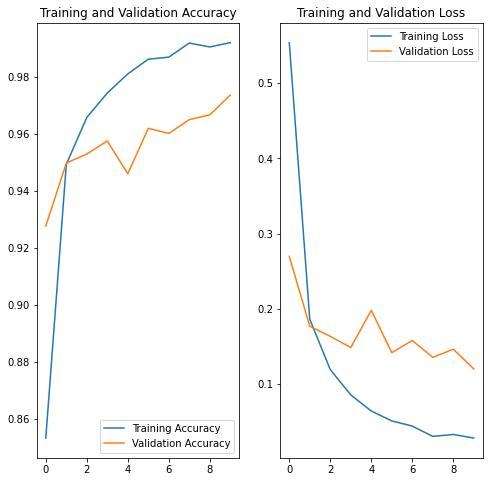

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model') # Save trained model

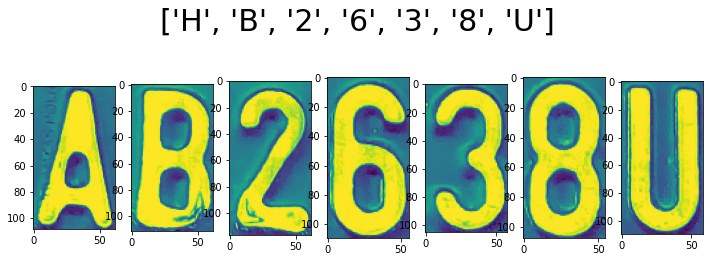

In [113]:
model = keras.models.load_model('/kaggle/working/my_model')

# display(imgs[index])
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
predictedPlat=[]


for index in range(0, len(imgs)):
    image =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    char_crop = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
#     display(char_crop)

    # preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)
    # agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

#     print(class_names[np.argmax(score)])
#     ax.imshow(image)
    predictedPlat.append(class_names[np.argmax(score)])
    
_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,predictedPlat,fontsize=30,ha='center')
plt.show()